In [1]:
from itertools  import combinations
from matplotlib import pyplot, gridspec
from matplotlib import ticker
from networkx   import *
from numpy      import array, matmul, mean, round
from pandas     import DataFrame, options
from random     import choice
from time       import time

from pyRN.SEA.meta_analysis   import get_abstractions_dfs, get_transitions_dfs
from pyRN.SEA.markov          import *
from pyRN.SEA.collections     import *
from pyRN.SEA.plot_markov_new import *

options.display.float_format = '{:,.5f}'.format

# Collective resilience

## 1. Introduction

Our previous analysis showed that resilience of chemical organizations is a property that is not only determined by the structure of the organizations but also by the context of the reaction network they are embedded in. This gives rise to the idea to look at resilience as a property that is shared between sets of organizations.

<img src=".\collective_resilience_hasse.drawio.png" style="width: 25%">

We divide the set of organisational boundaries between a set of organisations O and its complement Ō, as shown in the figure above. By combining transition probabilities between O and Ō as well as the transitions within O and Ō, we obtain a highly simplified model, as shown in the figure below.

<img src=".\collective_orgs.png" style="width: 25%">

Here again we can define local and global collective resilience similar to local and global resilience for individual organizations.

**Local collective resilience:**
The probability to transition from an organization from O to itself or to another organization from 0.

**Global collective resilience**
The probability to find the system in an organization from O at an arbitrary point in time.
<br>
<br>
<br>
Lets start by loading a Markov-model and choosing a subset of organizations to look at.

In [2]:
path = r'C:\Users\simon\Downloads\Bassi\Type_1\Ns20\RNG_Bassi_type_1_N20_Org_10_Id_14'

abstractions_df = get_abstractions_dfs(path, 2, 2)[0]
transitions_df  = get_transitions_dfs(path, 2, 2)[0]

organization_indices = list(range(11))

## 2. Calculation of global collective resilience

The global collective resilience of a set O of organization is simply the sum of the global resiliences of its organizations.

$r_{global}(O)=\Sigma_{o\in O}(r_{global}(o))$

In [3]:
display(abstractions_df)
print('Global collective resilience:')
print(global_collective_resilience(abstractions_df, organization_indices))

,abstraction,local_resilience,global_resilience,number of species,complexity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00000,0.00000,0,0.00000
1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.23684,0.00000,3,2.78333
2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...",0.29474,0.00000,5,6.84444
3,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...",0.32632,0.00000,6,8.34444
4,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...",0.48947,0.00000,6,8.46111
5,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...",0.48947,0.00000,7,9.96111
6,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, ...",0.28947,0.00598,9,8.26667
7,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, ...",0.35263,0.04084,10,10.26667
8,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, ...",0.73684,0.28046,11,11.88333
9,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, ...",0.41053,0.07708,11,11.76667


Global collective resilience:
0.9999999999999938


## 3. Calculation of local collective resilience

The local collective resilience obviously depends on the transitions starting from organizations in O.<br>
Additionaly we need to know the distribution of the probabilities to find the system in a specific organization given we know that is in some organization of O.<br>

$r_{local}(O)=\Sigma_{o_1 \in O}(\Sigma_{o_2 \in O}(P(o_1 \rightarrow o_2)*P(o_1|O)))$

$P(o_1|O)$ can not be computed directly so we have to estimate it.

### 3.1. Estimator 1

We assume $P(o|O)=\frac{1}{|O|}$ for all $o \in O$

$r_{local}(O)=\frac{1}{|O|}\Sigma_{o_1 \in O}(\Sigma_{o_2 \in O}(P(o_1 \rightarrow o_2)))$


In [4]:
print('Estimated probability distribution:')
print([round(p,5) for p in conditional_probability_estimator_1(abstractions_df, transitions_df, organization_indices)])

print('\nEstimated local collective resilience:')
print(local_collective_resilience(abstractions_df, transitions_df, organization_indices, estimator=1))

Estimated probability distribution:
[0.09091, 0.09091, 0.09091, 0.09091, 0.09091, 0.09091, 0.09091, 0.09091, 0.09091, 0.09091, 0.09091]

Estimated local collective resilience:
1.0


### 3.2. Estimator 2

The local collective resilience obviously depends on the transitions starting from organizations in O.<br>
Additionaly we need to know the distribution of the probabilities to find the system in a specific organization given we know that is in some organization of O.<br>

$r_{local}(O)=\Sigma_{o_1 \in O}(\Sigma_{o_2 \in O}(P(o_1 \rightarrow o_2)*P(o_1|O)))$

We will estimate P(o_1|O) by creating a copy of the Markov-model where transitions from O to Ō are not possible.

1. Make a copy $M'$ of the Markov-model $M$
2. In $M'$ the Markov-model set all probabilities of transitions from O to Ō
3. In $M'$ scale probabilities in a way such that for every organization the sum of probabilities of transitions starting from it is $1$
4. For $M'$ calculate the stationary probability distribution $S$ assuming that the system is uniformly distributed among the organizations of O
5. Calculate the local resilience

In [5]:
print('Estimated probability distribution:')
print([round(p,5) for p in conditional_probability_estimator_2(abstractions_df, transitions_df, organization_indices)])

print('\nEstimated local collective resilience:')
print(local_collective_resilience(abstractions_df, transitions_df, organization_indices, estimator=2))

Estimated probability distribution:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00598, 0.04084, 0.28046, 0.07708, 0.59565]

Estimated local collective resilience:
1.0


### 3.3. Estimator 3

We will estimate P(o_1|O) by rescaling the individual global resiliences of the organizations in O.<br>
If the sum of global resiliences of the organizations in O equals 0 we will use the estimator 2

In [6]:
print('Estimated probability distribution:')
print([round(p,5) for p in conditional_probability_estimator_3(abstractions_df, transitions_df, organization_indices)])

print('\nEstimated local collective resilience:')
print(local_collective_resilience(abstractions_df, transitions_df, organization_indices, estimator=3))

Estimated probability distribution:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00598, 0.04084, 0.28046, 0.07708, 0.59565]

Estimated local collective resilience:
1.0


### 3.4. Evaluating the accuracy of the estimates

We need to know the quality of the estimations made by the estimators.

If we know the local collective resilience for O and Ō we also know the probabilities to transition from O to Ō or vice versa.<br>
This allows us to create a Markov-model for only O and Ō as shown in the second figure in the Introduction.

\begin{align*}
T &= 
\begin{bmatrix}
    r_{local}(O) & 1-r_{local}(Ō) \\
    1-r_{local}(O) & r_{local}(Ō) \\  
\end{bmatrix}
\end{align*}

This allows us to compute an estimate for the global collective resilience which we can compare to the actual global collective resilience we can compute as shown in section 2.
But first we need to know if the values can actually


In [7]:
paths = [
        r'C:\Users\simon\Downloads\Bassi\Type_1\Ns20\RNG_Bassi_type_1_N20_Org_6_Id_0',
        r'C:\Users\simon\Downloads\Bassi\Type_1\Ns20\RNG_Bassi_type_1_N20_Org_6_Id_1',
        r'C:\Users\simon\Downloads\Bassi\Type_1\Ns20\RNG_Bassi_type_1_N20_Org_8_Id_5',
        r'C:\Users\simon\Downloads\Bassi\Type_1\Ns20\RNG_Bassi_type_1_N20_Org_8_Id_6',
        r'C:\Users\simon\Downloads\Bassi\Type_2\Ns20\RNG_Bassi_type_2_N20_Org_6_Id_0',
        r'C:\Users\simon\Downloads\Bassi\Type_2\Ns20\RNG_Bassi_type_2_N20_Org_6_Id_1',
        r'C:\Users\simon\Downloads\Bassi\Type_2\Ns20\RNG_Bassi_type_2_N20_Org_8_Id_2',
        r'C:\Users\simon\Downloads\Bassi\Type_2\Ns20\RNG_Bassi_type_2_N20_Org_8_Id_3',
        r'C:\Users\simon\Downloads\Bassi\Type_3\Ns20\RNG_Bassi_type_3_N20_Org_6_Id_1',
        r'C:\Users\simon\Downloads\Bassi\Type_3\Ns20\RNG_Bassi_type_3_N20_Org_6_Id_2',
        r'C:\Users\simon\Downloads\Bassi\Type_3\Ns20\RNG_Bassi_type_3_N20_Org_8_Id_10',
        r'C:\Users\simon\Downloads\Bassi\Type_3\Ns20\RNG_Bassi_type_3_N20_Org_8_Id_16',
        r'C:\Users\simon\Downloads\Bassi\Type_4\Ns20\RNG_Bassi_type_4_N20_Org_6_Id_1',
        r'C:\Users\simon\Downloads\Bassi\Type_4\Ns20\RNG_Bassi_type_4_N20_Org_6_Id_2',
        r'C:\Users\simon\Downloads\Bassi\Type_4\Ns20\RNG_Bassi_type_4_N20_Org_8_Id_9',
        r'C:\Users\simon\Downloads\Bassi\Type_4\Ns20\RNG_Bassi_type_4_N20_Org_8_Id_11',
        r'C:\Users\simon\Downloads\Bassi\Type_5\Ns20\RNG_Bassi_type_5_N20_Org_6_Id_0',
        r'C:\Users\simon\Downloads\Bassi\Type_5\Ns20\RNG_Bassi_type_5_N20_Org_6_Id_1',
        r'C:\Users\simon\Downloads\Bassi\Type_5\Ns20\RNG_Bassi_type_5_N20_Org_8_Id_0',
        r'C:\Users\simon\Downloads\Bassi\Type_5\Ns20\RNG_Bassi_type_5_N20_Org_8_Id_2'
        ]

def test_estimator(estimator, paths, max_pertsize, strongly_connected=True):
    '''
    Parameters:
        estimator          (int),  an estimator for local resilience
        path               (list), a list of folderpaths
        max_pertsize       (int)
        strongly_connected (bool)
    Returns:
        deviations (list),
        bins       (list),
    Compares global collective resiliences calculated from estimated local collective resiliences
    with the actual global collective resiliences
    '''
    estimates_glo = []
    real_values   = []
    bins          = [0]

    for path in paths:
        abstractions_df = get_abstractions_dfs(path, max_pertsize, max_pertsize)[0]
        transitions_df  = get_transitions_dfs(path,  max_pertsize, max_pertsize)[0]
        graph           = transition_graph_from_dataframes(abstractions_df, transitions_df)
        sets            = get_combinations(list(range(abstractions_df.shape[0])))
        if strongly_connected:
            sets        = [s for s in sets if is_strongly_connected(graph.subgraph(s))]
        else:
            sets        = [s for s in sets if is_weakly_connected(graph.subgraph(s))]
        estimates_glo  += [estimate_global_collective_resilience(abstractions_df, transitions_df, organization_indices, estimator) for organization_indices in sets]
        real_values    += [global_collective_resilience(abstractions_df, organization_indices) for organization_indices in sets]
        bins.append(len(sets)+bins[-1])

    deviations = abs(array(real_values)-array(estimates_glo))
    
    return deviations, bins

start    = time()
deviations_1, bins_1 = test_estimator(1, paths, 2)
end      = time()
minutes  = int((end-start)/60)
seconds = int((end-start)-minutes)
print(f'Estimator 1 took {minutes} minutes {seconds} seconds')
print(f'Mean deviation: {round(mean(deviations_1),10)}\n')

start   = time()
deviations_2, bins_2 = test_estimator(2, paths, 2)
end     = time()
minutes = int((end-start)/60)
seconds = int((end-start)-minutes)
print(f'Estimator 2 took {minutes} minutes {seconds} seconds')
print(f'Mean deviation: {round(mean(deviations_2),10)}\n')

start   = time()
deviations_3, bins_3 = test_estimator(3, paths, 2)
end     = time()
minutes = int((end-start)/60)
seconds = int((end-start)-minutes)
print(f'Estimator 3 took {minutes} minutes {seconds} seconds')
print(f'Mean deviation: {round(mean(deviations_3),10)}\n')

print(f'Sample: {bins_1[-1]} connected organizations')

Estimator 1 took 0 minutes 44 seconds
Mean deviation: 0.1056335958

Estimator 2 took 5 minutes 303 seconds
Mean deviation: 0.0067337934

Estimator 3 took 0 minutes 52 seconds
Mean deviation: 2.325e-07

Sample: 1434 connected organizations


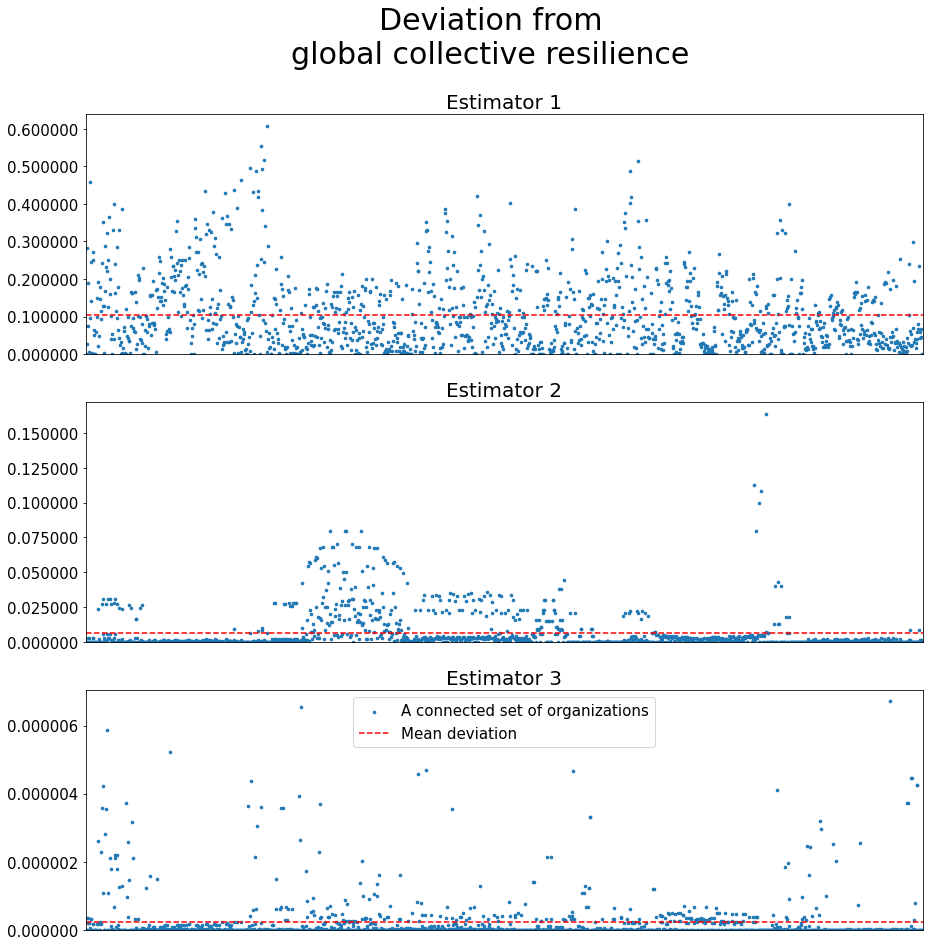

In [8]:
def plot_deviations(deviations, bins, axes, show_bins=False):

    mean_dev = mean(deviations)

    axes.scatter([i for i in range(len(deviations))], deviations, label='A connected set of organizations', s=6.66)
    axes.plot([0,len(deviations)], [mean_dev, mean_dev], label='Mean deviation', color='red', linestyle='dashed')

    if show_bins:
        for i, bin in enumerate(bins):
            axes.plot([bin, bin], [0, max(deviations)], color='black')

    axes.tick_params(labelsize=15)
    axes.set_xlim(xmin=0,xmax=bins[len(bins)-1])
    axes.set_ylim(ymin=0)
    axes.set_xticks([])
    axes.set_xticklabels([]) 
    axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))

fig, axes = pyplot.subplots(3, figsize=(15,15))

fig.suptitle('Deviation from\nglobal collective resilience', fontsize=30)

axes[0].set_title('Estimator 1', fontsize=20)
axes[1].set_title('Estimator 2', fontsize=20)
axes[2].set_title('Estimator 3', fontsize=20)

plot_deviations(deviations_1, bins_1, axes[0])
plot_deviations(deviations_2, bins_3, axes[1])
plot_deviations(deviations_3, bins_3, axes[2])

pyplot.legend(fontsize=15, loc='upper center',  ncol=1)
pyplot.show()


Clearly the estimator 3 is the best, it is both fast and accurate.

## 4. Finding interesting sets of organizations

What are properties of interesting sets of organizations?<br>
•	High collective resiliences<br>
•	Low number of organizations included<br>
•	Connectedness<br>

### 4.1 Global collective resilience

We will determine them using a simple greedy algorithm that starts with the full set of organizations and succesively removes organizations in a way that the remaining organizations stay connected and have the highest collective resilience possible.
We can plot the curve of collective resilience of the remaining organizations over the course of the procedure.

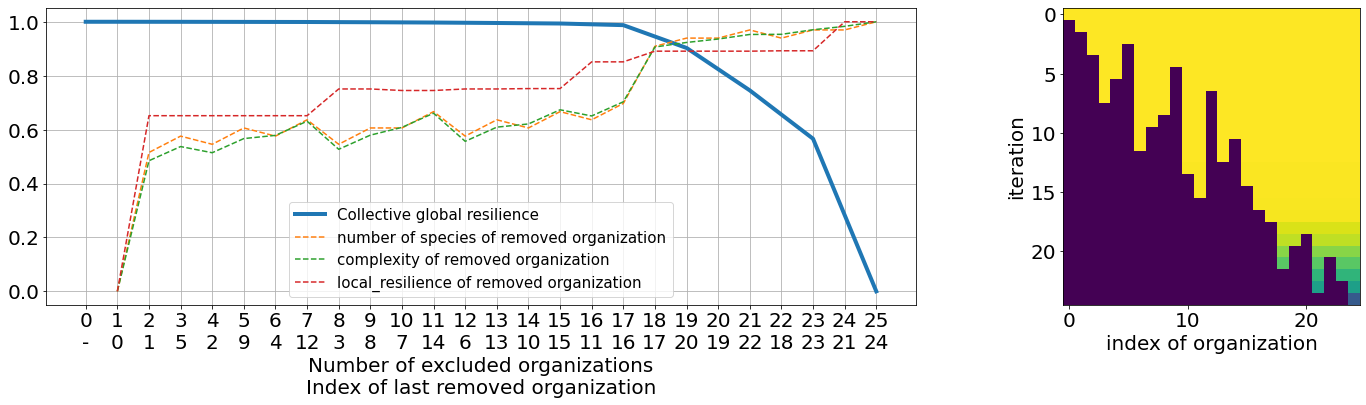

In [9]:
path = r'C:\Users\simon\Downloads\Rand_Net_markov\Ns40\RN_Ns_40_Norg_24_id_316'

abstractions_df = get_abstractions_dfs(path, 2, 2)[0]
transitions_df  = get_transitions_dfs(path, 2, 2)[0]

global_resilience_course, sequence_of_removals = algorithm(abstractions_df, transitions_df)

fig = pyplot.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], height_ratios=[1, 1])
a1 = pyplot.subplot(gs[0])
a2 = pyplot.subplot(gs[1])
plot_for_algorithm(abstractions_df, global_resilience_course, sequence_of_removals, a1)
plot_removal_sequence(sequence_of_removals, global_resilience_course, a2) 
pyplot.show()

### 4.2 Local collective resilience

Sets of organizations can display higher local resilience than their organizations.

Let's look at one Markov-model and see if we can find such sets.

,abstraction,local_resilience,global_resilience,number of species,complexity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00000,0.00000,0,0.00000
1,"[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...",0.28947,0.00000,7,4.18470
2,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.28947,0.00000,9,6.24423
3,"[1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, ...",0.63158,0.00909,13,5.82143
4,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...",0.63158,0.00909,15,7.88095
5,"[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",0.89474,0.49091,16,6.54762
6,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.89474,0.49091,18,8.60714


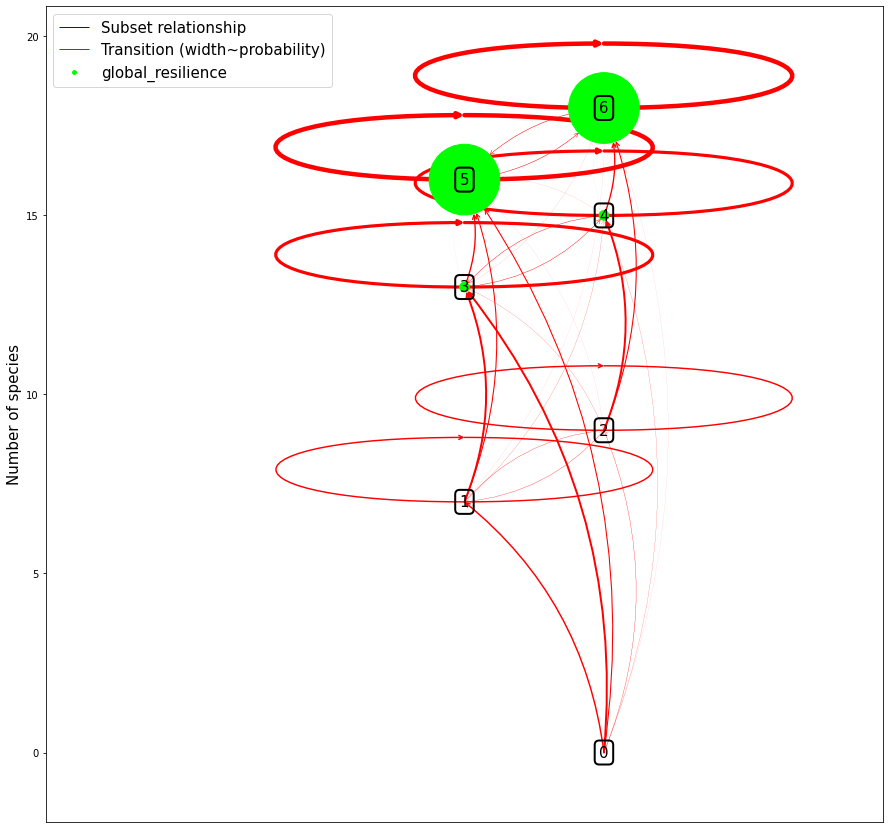

,set,local collective resilience
0,"(1, 2)",0.34737
1,"(3, 4)",0.71579
2,"(5, 6)",0.99474
3,"(3, 5, 6)",0.99662
4,"(4, 5, 6)",0.99662
5,"(3, 4, 5, 6)",1.00000


In [10]:
path      = r'C:\Users\simon\Downloads\Bassi\Type_1\Ns20\RNG_Bassi_type_1_N20_Org_6_Id_0'
pert_size = 2

abstractions_df  = get_abstractions_dfs(path, pert_size, pert_size)[0]
transitions_df   = get_transitions_dfs(path, pert_size, pert_size)[0]
cooperative_sets = find_cooperative_sets(abstractions_df, transitions_df, strongly_connected=True)

fig, axes = pyplot.subplots(figsize=(15,15))
plot_markov(axes, abstractions_df, transitions_df, shift_x=True, node_size='global_resilience', index_labels=True)
axes.set_xlim(xmin=1, xmax=4)
display(abstractions_df)
pyplot.show()
display(DataFrame(cooperative_sets))